In [ ]:
import datetime 
import itertools
import os

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline


In [20]:
rootPath = '../../dataset-10/'
loggingLevels = ['TRACE', 'DEBUG', 'INFO', 'WARN', 'ERROR']

def plot_log_files_starting_with(file_prefix):
    all_log_entries = get_all_log_entries(file_prefix)
    
    aggregated = [x['log_date'] for x in all_log_entries]
    grouped = itertools.groupby(aggregated, lambda x: x.date())
    count_per_day = [*map(lambda x: to_dates_count(*x), grouped)]
    count_per_day.sort(key=lambda x: x["log_date"])
    aggregated_dates = [x["log_date"] for x in count_per_day]
    
    mat_dates = mdates.date2num(aggregated_dates)
    mat_values = [x["number_of"] for x in count_per_day]
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.plot_date(mat_dates, mat_values, '-o')
    
def get_all_log_entries(file_prefix):
    all_log_entries = []
    for filename in os.listdir(rootPath):
        if filename.endswith('.log') and filename.startswith(file_prefix):
            filepath = rootPath + filename
            all_log_entries.extend(process_file(all_log_entries,filepath))
    return all_log_entries
    
def process_file(all_log_entries, filepath):
    f = open(filepath, "r+")
    allLines = f.readlines()
    parsedDates = []
    logEntries = []
    for line in allLines:
        process_entry(filepath,line,logEntries,parsedDates)
    f.close()
    return logEntries
    
def process_entry(filepath, line, logEntries, parsedDates):
    if any(line.startswith(x) for x in loggingLevels):
        splittedLine = line.split(None, 6)
        newEntry = dict(log_level = splittedLine[0])
        process_date(newEntry,parsedDates,splittedLine)
        process_thread_name(filepath,newEntry,splittedLine)
        process_logger_name(newEntry,splittedLine)
        newEntry['msg'] = splittedLine[6]
        logEntries.append(newEntry)
    else:
        append_line_to_last_msg(line,logEntries)
        
def append_line_to_last_msg(line, logEntries):
    if logEntries:
        logEntries[-1]['msg'] = logEntries[-1]['msg'] + line

def process_logger_name(newEntry, splittedLine):
    if splittedLine[4] != '':
        loggerName = splittedLine[4].split('.')[-1]
        if loggerName != '':
            newEntry['logger_name'] = loggerName
    
def process_thread_name(filepath, newEntry, splittedLine):
    if splittedLine[3] != '':
        if 'timepot' in filepath:
            threadNameWithUserId = splittedLine[3].split('][uid:')
            if len(threadNameWithUserId) > 0:
                threadName = threadNameWithUserId[0].replace('[', '')
                if threadName != '':
                    newEntry['thread_name'] = threadName
            if len(threadNameWithUserId) > 1: 
                userId = threadNameWithUserId[1].replace(']', '')
                if userId.isdigit():
                    newEntry['user_id'] = userId
        else:
            threadName = splittedLine[3][1:-1]
            if threadName != '':
                newEntry['thread_name'] = threadName
                
def process_date(newEntry, parsedDates, splittedLine):
    if splittedLine[1] != '' and splittedLine[2] != '':
        parsedDate = datetime.datetime.strptime(splittedLine[1] + splittedLine[2], '%Y-%m-%d%H:%M:%S.%f')
        parsedDates.append(parsedDate)
        newEntry['log_date'] = parsedDate
    
def to_dates_count(x, y):
    return dict(log_date=x, number_of=len(list(y)))

In [21]:
def plot_log_files_histogram_starting_with(file_prefix):
    all_log_entries = get_all_log_entries(file_prefix)
    
    aggregated = [x['log_date'] for x in all_log_entries]
    aggregated.sort(key=lambda x: to_total_minutes_time_slot(x))
    grouped = itertools.groupby(aggregated, key=lambda x: to_total_minutes_time_slot(x))
    count_per_day = [*map(lambda x: to_time_slots(*x), grouped)]
    mat_values = []
    for ts in range(0, 49): 
        number_of = filter(lambda x: x["time_slot"] == ts, count_per_day)
        mat_values.append(next(map(lambda x: x["number_of"], number_of), 0))
    
def to_total_minutes_time_slot(dt):
    total_minutes = (dt.hour * 60) + dt.minute
    return int(total_minutes / 30)
    
def to_time_slots(x, y):
    return dict(time_slot=x, number_of=len(list(y)))   

## Liczba wpisów logów timepot.*.log 
Główne logi aplikacji Springowej, łącznie z wyjątkami oraz niektórymi zapytaniami SQL 

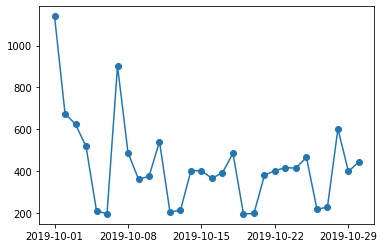

In [22]:
plot_log_files_starting_with('timepot.2019-10')

## Liczba wpisów logów message.*.log
Komunikacja przychodząca HTTP po REST

In [ ]:
plot_log_files_starting_with('message.2019-10')

## Liczba wpisów logów frontend.*.log
Dodatkowe logi frontendowe (najczęściej zawierające wystąpienia błędów) przesyłane poprzez dedykowaną usługę

In [ ]:
plot_log_files_starting_with('frontend.2019-10')

## Liczba wpisów logów braintree.*.log
Integracja z systemem płatności Braintree

In [ ]:
plot_log_files_starting_with('braintree.2019-03')

In [23]:
plot_log_files_histogram_starting_with('timepot.2019-10')

In [ ]:
plot_log_files_histogram_starting_with('message.2019-10')

In [ ]:
plot_log_files_histogram_starting_with('frontend.2019-10')

In [ ]:
plot_log_files_histogram_starting_with('braintree.2019-10')
